In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('rainfall.csv')
df.head()


,rainfall,temperature,humidity,wind_speed
0,1,15.2,78,8.5
1,0,17.8,65,5.2
2,0,20.1,52,3.1
3,0,18.6,71,6.7
4,1,14.8,82,9.3


In [3]:
df.shape


(53, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rainfall     53 non-null     int64  
 1   temperature  53 non-null     float64
 2   humidity     53 non-null     int64  
 3   wind_speed   53 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 1.8 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rainfall,53.0,0.490566,0.504695,0.0,0.0,0.0,1.0,1.0
temperature,53.0,17.950943,2.500663,13.9,16.1,17.8,19.4,23.4
humidity,53.0,69.245283,11.969361,44.0,62.0,72.0,78.0,89.0
wind_speed,53.0,6.403774,2.209069,2.1,4.7,6.7,8.3,10.5


In [6]:
df.isnull().sum()


rainfall       0
temperature    0
humidity       0
wind_speed     0
dtype: int64

In [7]:
df.columns


Index(['rainfall', 'temperature', 'humidity', 'wind_speed'], dtype='object')

In [8]:
df.rename(str.strip,
		axis='columns', 
		inplace=True)

df.columns


Index(['rainfall', 'temperature', 'humidity', 'wind_speed'], dtype='object')

In [9]:
for col in df.columns:
  if df[col].isnull().sum() > 0:
      val = df[col].mean()
      df[col] = df[col].fillna(val)
	
df.isnull().sum().sum()


0

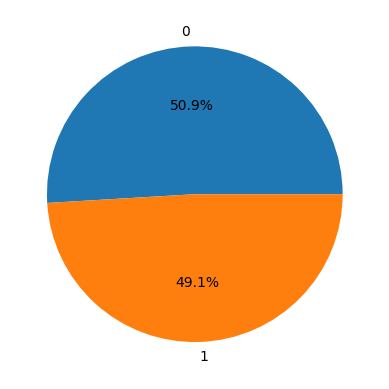

In [10]:
plt.pie(df['rainfall'].value_counts().values,
		labels = df['rainfall'].value_counts().index,
		autopct='%1.1f%%')
plt.show()


In [11]:
df.groupby('rainfall').mean()


,temperature,humidity,wind_speed
rainfall,,,
0,19.585185,61.185185,5.103704
1,16.253846,77.615385,7.753846


In [12]:
features = list(df.select_dtypes(include = np.number).columns)
print(features)


['rainfall', 'temperature', 'humidity', 'wind_speed']


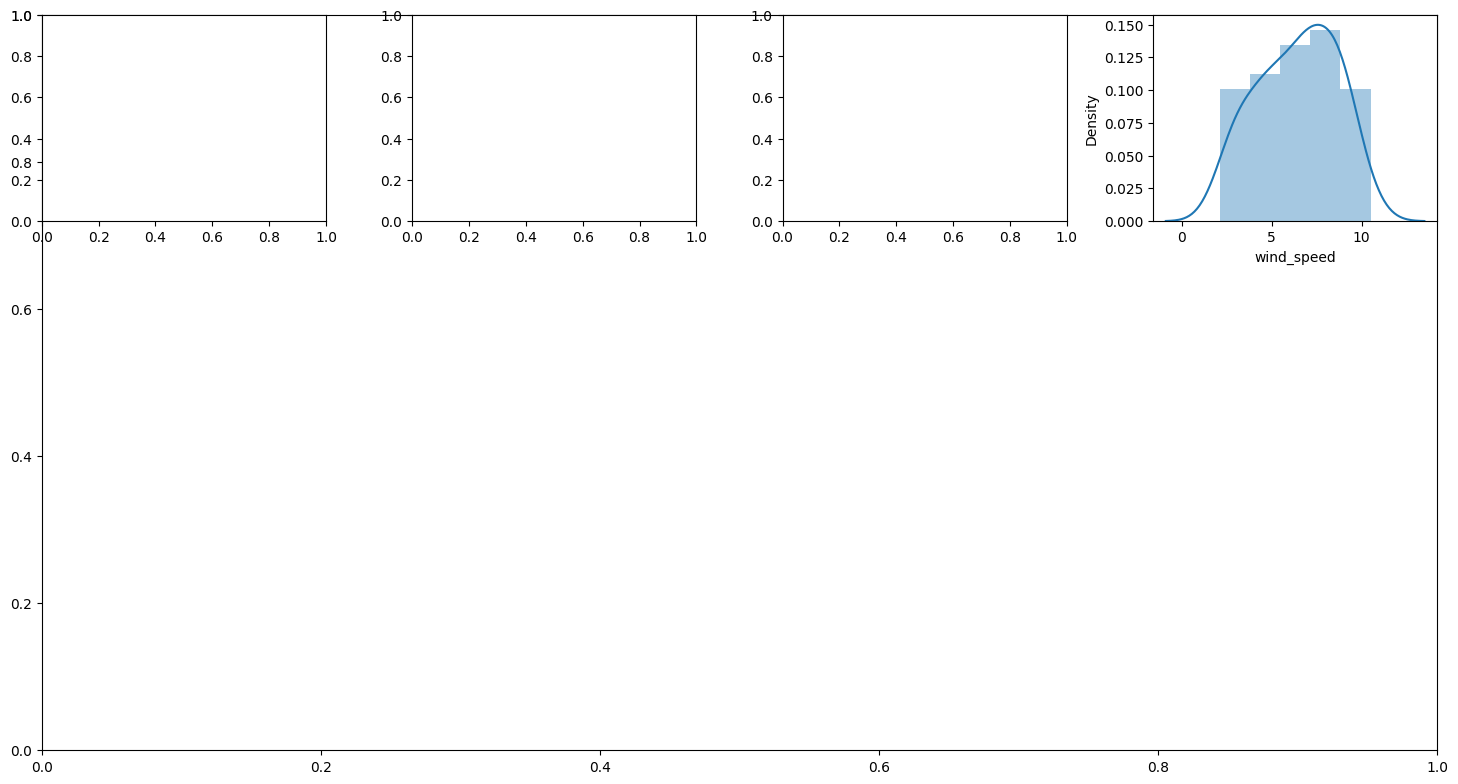

In [13]:
plt.subplots(figsize=(15,8))

for i, col in enumerate(features):
    plt.subplot(3,4, i + 1)
sb.distplot(df[col])
plt.tight_layout()
plt.show()


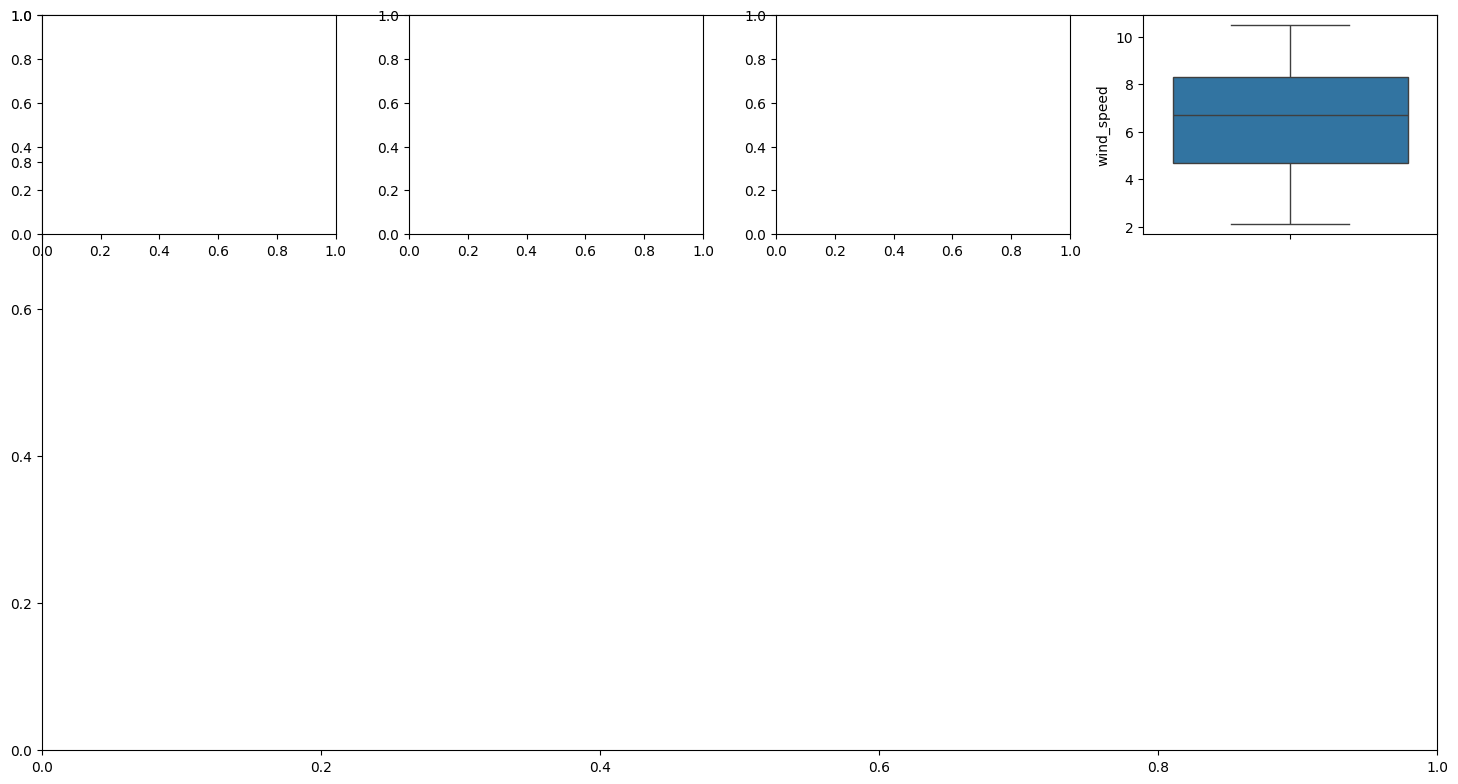

In [14]:
plt.subplots(figsize=(15,8))

for i, col in enumerate(features):
    plt.subplot(3,4, i + 1)
sb.boxplot(df[col])
plt.tight_layout()
plt.show()


In [15]:
df.replace({'yes':1, 'no':0}, inplace=True)


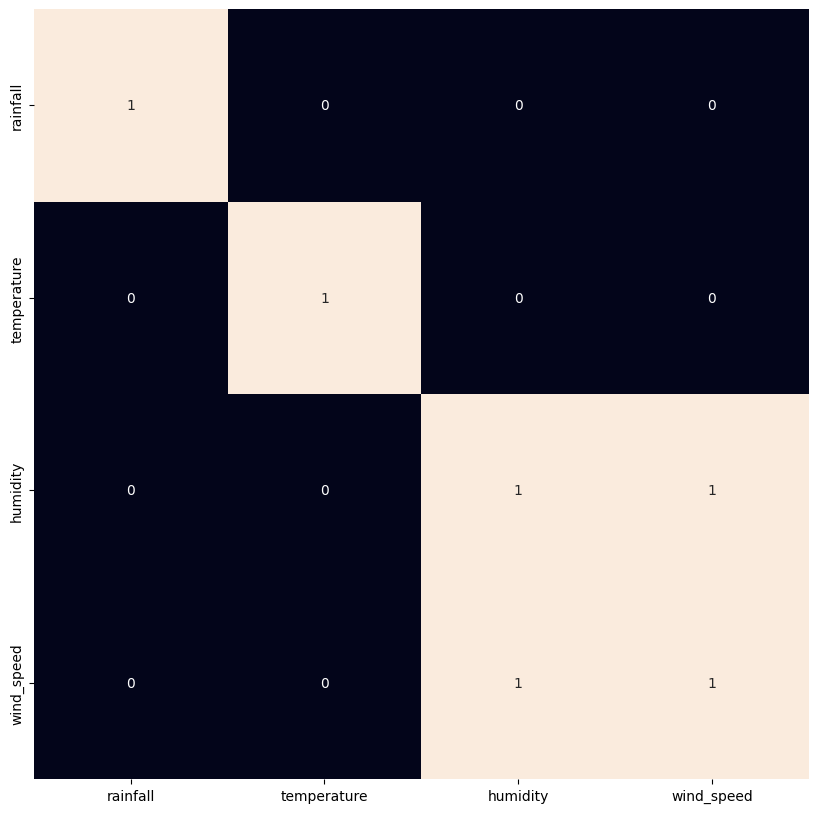

In [16]:
plt.figure(figsize=(10,10))
sb.heatmap(df.corr() > 0.8,
		annot=True,
		cbar=False)
plt.show()


In [17]:
features = df.drop(['rainfall'], axis=1)
target = df.rainfall


In [18]:
X_train, X_val, \
	Y_train, Y_val = train_test_split(features,
									target,
									test_size=0.2,
									stratify=target,
									random_state=2)


ros = RandomOverSampler(sampling_strategy='minority',
						random_state=22)
X, Y = ros.fit_resample(X_train, Y_train)


In [19]:

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)


In [20]:
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf', probability=True)]

for i in range(3):
    models[i].fit(X, Y)
    print(f'{models[i]} : ')
    train_preds = models[i].predict_proba(X) 
    print('Training Accuracy : ', metrics.roc_auc_score(Y, train_preds[:,1]))
    val_preds = models[i].predict_proba(X_val) 
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, val_preds[:,1]))
    print()


LogisticRegression() : 
Training Accuracy :  0.9126984126984126
Validation Accuracy :  0.9333333333333333

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.9943310657596371
Validation Accuracy :  0.7166666666666667

SVC(probability=True) : 
Training Accuracy :  0.9

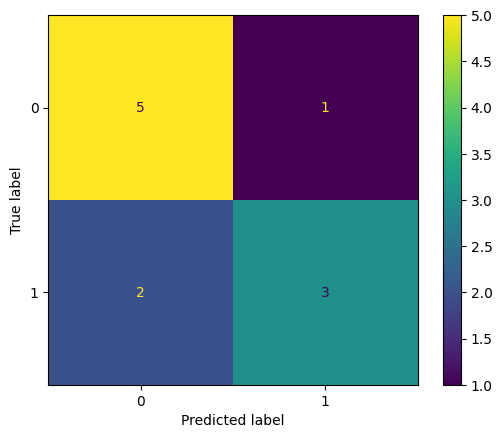

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(models[2], X_val, Y_val)
plt.show()


In [22]:
print(metrics.classification_report(Y_val,
									models[2].predict(X_val)))


              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.75      0.60      0.67         5

    accuracy                           0.73        11
   macro avg       0.73      0.72      0.72        11
weighted avg       0.73      0.73      0.72        11

